<a href="https://colab.research.google.com/github/Bruna-gc/NeuralNetworksResearch/blob/main/(exploring_greater_N_M)W_Assymetry_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# GPU Setup and Optimization
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from matplotlib.ticker import FixedLocator, FixedFormatter

Starting Delta=1 Characterization Analysis

=== Processing All Connections: N=200, M=100 ===
  Progress: 1/21 - Load 0.00: 46.7±49.9%
  Progress: 10/21 - Load 0.09: 0.0±0.0%
  Progress: 20/21 - Load 0.19: 0.0±0.0%

=== Processing All Connections: N=400, M=200 ===
  Progress: 1/21 - Load 0.00: 50.0±50.0%
  Progress: 10/21 - Load 0.09: 0.0±0.0%
  Progress: 20/21 - Load 0.19: 0.0±0.0%

=== Processing All Connections: N=600, M=300 ===
  Progress: 1/21 - Load 0.00: 43.3±49.6%
  Progress: 10/21 - Load 0.09: 0.0±0.0%
  Progress: 20/21 - Load 0.19: 0.0±0.0%

=== Processing All Connections: N=800, M=400 ===
  Progress: 1/21 - Load 0.00: 53.3±49.9%
  Progress: 10/21 - Load 0.09: 0.0±0.0%
  Progress: 20/21 - Load 0.19: 0.0±0.0%

=== Processing Neighbor Neurons: N=200, M=100 ===
  Progress: 1/21 - Load 0.00: 100.0±0.0%
  Progress: 10/21 - Load 0.09: 34.3±14.4%
  Progress: 20/21 - Load 0.19: 0.0±0.0%

=== Processing Neighbor Neurons: N=400, M=200 ===
  Progress: 1/21 - Load 0.00: 100.0±0.0%
  Progr

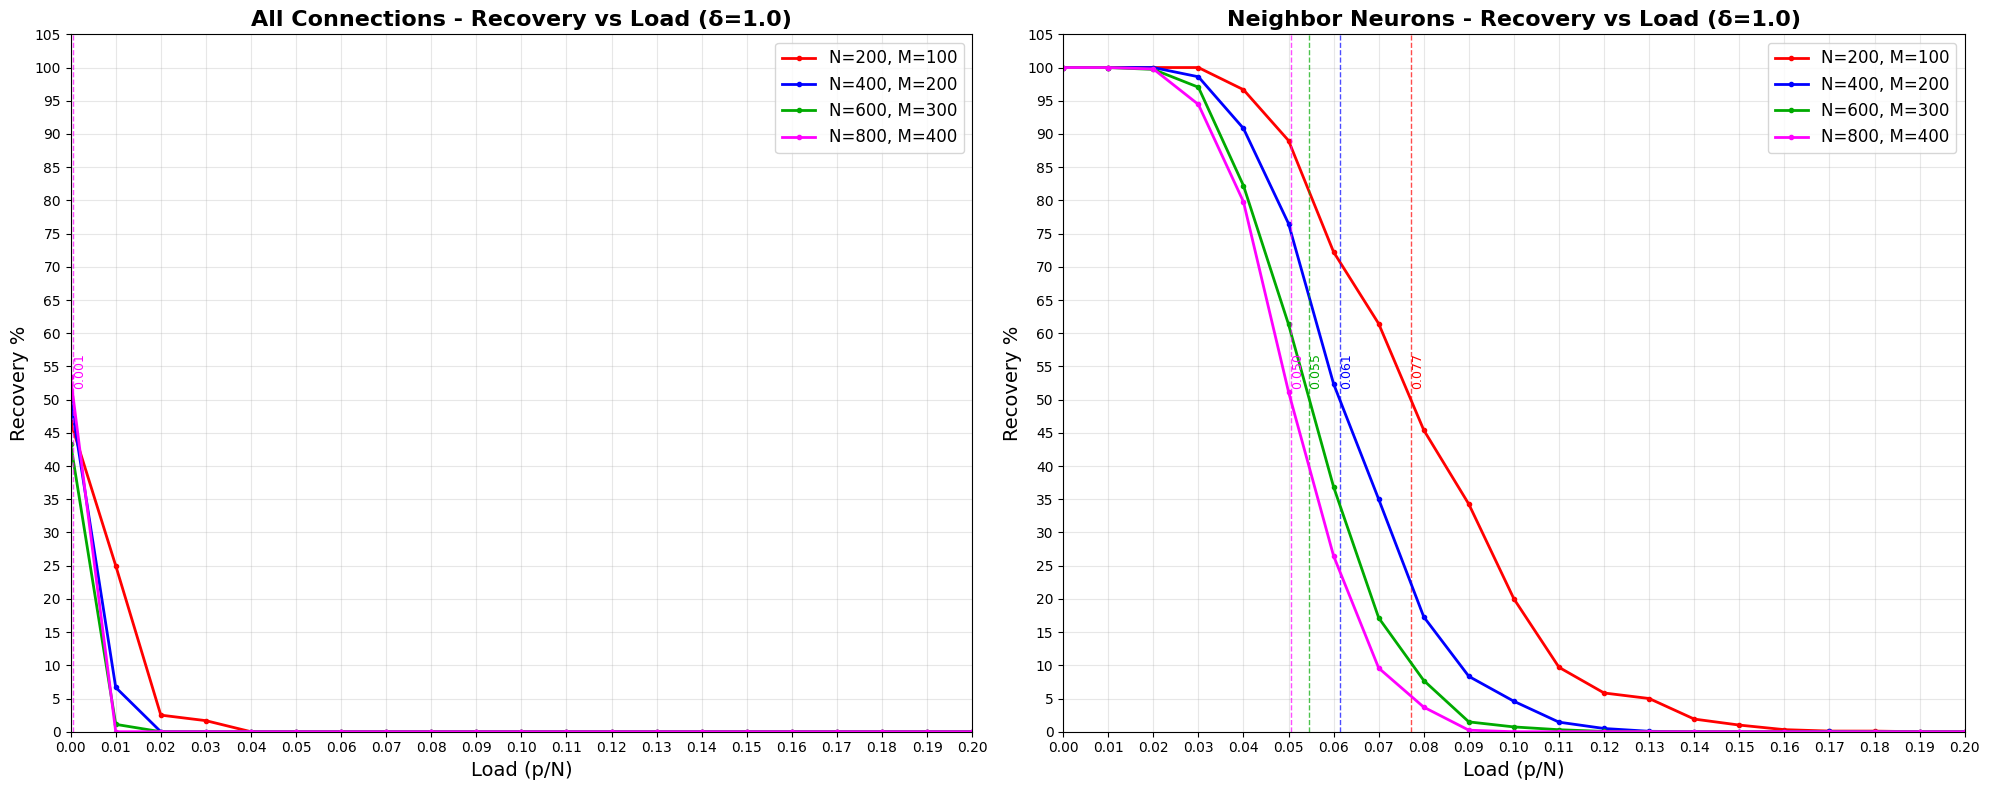


Analysis Complete!


In [ ]:
# GPU Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Enable optimizations for better GPU performance
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

# Optimized Functions (GPU-accelerated)
def create_patterns(size, num_patterns):
    """Create random bipolar patterns (+1, -1) using PyTorch - GPU optimized"""
    patterns = torch.randint(0, 2, (num_patterns, size), device=device, dtype=torch.float32)
    patterns = 2 * patterns - 1  # Convert 0,1 to -1,1
    return patterns

def train(patterns, N, lambda_):
    """Train network by Hebbian learning - fully PyTorch GPU optimized"""
    # Use optimized matrix multiplication
    weights = torch.mm(patterns.T, patterns)
    # Normalize FIRST, then set diagonal
    weights = weights / N
    weights.fill_diagonal_(lambda_)
    return weights

def asymmetry(weights, delta, asymmetry_type='single', asymmetry_num=1, N_neurons=None):
    """
    Apply asymmetry to weight matrix

    Args:
        weights: Weight matrix to modify
        delta: Asymmetry parameter
        asymmetry_type: 'single', 'pair', 'all', or 'neighbors'
        asymmetry_num: Number of connections to modify (for 'single' and 'pair')
        N_neurons: Number of neurons to modify (for 'neighbors' type)
    """
    W = weights.clone()  # Always clone to preserve original

    if asymmetry_type == 'all':
      upper = torch.triu(W, diagonal=1)
      lower = torch.tril(W, diagonal=-1)
      diag = torch.diag(torch.diag(W))
      W = upper*(1 + delta) + lower*(1 - delta) + diag


    elif asymmetry_type == 'neighbors':
        # Case 4: Modify weights for N_neurons consecutive (neighboring) neurons
        if N_neurons is None:
            N_neurons = weights.shape[0] // 4  # Default to 25% of neurons

        rows, cols = W.shape
        # Select a random starting position for consecutive neurons
        start_idx = torch.randint(0, rows - N_neurons + 1, (1,), device=device).item()
        neighbor_indices = torch.arange(start_idx, start_idx + N_neurons, device=device)

        # Create meshgrid for all combinations of neighbor indices
        i_indices, j_indices = torch.meshgrid(neighbor_indices, neighbor_indices, indexing='ij')

        # Flatten the indices
        i_flat = i_indices.flatten()
        j_flat = j_indices.flatten()

        # Remove diagonal elements (i == j)
        non_diagonal = i_flat != j_flat
        i_flat = i_flat[non_diagonal]
        j_flat = j_flat[non_diagonal]

        # Apply asymmetry: upper triangular gets (1+delta), lower gets (1-delta)
        upper_mask = i_flat < j_flat
        lower_mask = i_flat > j_flat

        # Apply modifications
        W[i_flat[upper_mask], j_flat[upper_mask]] *= (1 + delta)
        W[i_flat[lower_mask], j_flat[lower_mask]] *= (1 - delta)

    return W

def create_noisy_input(pattern, num_flips):
    """Create noisy input by flipping random bits - PyTorch GPU optimized"""
    noisy_input = pattern.clone()
    if num_flips > 0:
        indices = torch.randperm(len(pattern), device=device)[:num_flips]
        noisy_input[indices] *= -1
    return noisy_input

def recall(W, input_pattern, steps=5):
    """Recall pattern from noisy input - fully PyTorch GPU optimized"""
    # Handle single pattern input
    if input_pattern.ndim == 1:
        input_pattern = input_pattern.unsqueeze(0)
    patterns = input_pattern.clone()

    for _ in range(steps):
        # Vectorized computation for all patterns at once
        net_input = torch.mm(patterns, W.T)
        # Ensure strictly -1 or 1 (no zeros) - GPU optimized
        patterns = torch.where(net_input >= 0, 1.0, -1.0)
    return patterns.squeeze() if patterns.shape[0] == 1 else patterns

def recovered_patterns(recalled_patterns, patterns):
    """Count recovered patterns - fully PyTorch GPU optimized"""
    # Handle single pattern comparison
    if recalled_patterns.ndim == 1:
        recalled_patterns = recalled_patterns.unsqueeze(0)
    if patterns.ndim == 1:
        patterns = patterns.unsqueeze(0)
    # Vectorized comparison - GPU optimized
    matches = torch.all(recalled_patterns == patterns, dim=1)
    return int(torch.sum(matches).item())

def get_recovered_percent(recalled_patterns, patterns):
    """Get recovery percentage - fully PyTorch GPU optimized"""
    return recovered_patterns(recalled_patterns, patterns) / patterns.shape[0] * 100

def batch_recall_patterns(W, patterns, num_flips, steps=5):
    """Process patterns with a single noise level for better GPU utilization"""
    # Create all noisy inputs at once with the same noise level
    noisy_patterns = []
    for pattern in patterns:
        noisy_pattern = create_noisy_input(pattern, num_flips)
        noisy_patterns.append(noisy_pattern)

    # Stack and process in batch
    noisy_batch = torch.stack(noisy_patterns)
    recalled_batch = recall(W, noisy_batch, steps)

    # Calculate recovery percentage
    recovery_percent = get_recovered_percent(recalled_batch, patterns)
    return recovery_percent

def run_recovery_analysis_delta_1(N, M, asymmetry_type, iterations=50):
    """
    Run recovery analysis specifically for delta=1 with fine load resolution

    Args:
        N: Network size
        M: Number of stored patterns
        asymmetry_type: 'all' or 'neighbors'
        iterations: Number of iterations for averaging
    """
    delta = 1.0
    noise_level = 0  # No noise for clean analysis

    # Fine load resolution: 0.01 to 0.50 in steps of 0.01
    load_values = np.arange(0.0, 0.21, 0.01)

    # Store results
    recovery_results = []
    recovery_std = []

    # print(f"Analyzing N={N}, M={M}, asymmetry={asymmetry_type}, delta={delta}")
    # print(f"Load range: {load_values[0]:.2f} to {load_values[-1]:.2f} (steps: {len(load_values)})")

    for i, load in enumerate(load_values):
        num_patterns = max(1, int(load * N))

        # Average over multiple iterations
        iteration_results = []

        for iteration in range(iterations):
            # Create patterns using M (stored patterns parameter)
            patterns = create_patterns(N, num_patterns)

            # Train network
            W = train(patterns, N, 0.0)  # lambda = 0 for standard Hopfield

            # Apply asymmetry with delta=1
            if asymmetry_type == 'neighbors':
                N_neurons = int(N / math.sqrt(2))  # As in original code
                W = asymmetry(W, delta, asymmetry_type, N_neurons=N_neurons)
            else:  # 'all'
                W = asymmetry(W, delta, asymmetry_type)

            # Test with no noise
            recovery_percentage = batch_recall_patterns(W, patterns, noise_level)
            iteration_results.append(recovery_percentage)

        # Calculate mean and standard deviation across iterations
        mean_recovery = np.mean(iteration_results)
        std_recovery = np.std(iteration_results)
        recovery_results.append(mean_recovery)
        recovery_std.append(std_recovery)

        # Progress indicator
        if (i + 1) % 10 == 0 or i == 0:
            print(f"  Progress: {i+1}/{len(load_values)} - Load {load:.2f}: {mean_recovery:.1f}±{std_recovery:.1f}%")

    return load_values, recovery_results, recovery_std

def find_50_percent_crossing(load_values, recovery_results):
    """Find the load value where recovery crosses 50%"""
    recovery_array = np.array(recovery_results)

    # Find indices where recovery is above and below 50%
    above_50 = recovery_array >= 50.0
    below_50 = recovery_array < 50.0

    if not np.any(above_50) or not np.any(below_50):
        return None  # No crossing found

    # Find the first transition from above to below 50%
    for i in range(len(recovery_array) - 1):
        if recovery_array[i] >= 50.0 and recovery_array[i + 1] < 50.0:
            # Linear interpolation between the two points
            x1, y1 = load_values[i], recovery_array[i]
            x2, y2 = load_values[i + 1], recovery_array[i + 1]

            # Interpolate to find exact crossing point
            crossing_load = x1 + (50.0 - y1) * (x2 - x1) / (y2 - y1)
            return crossing_load

    return None

def plot_delta_1_analysis():
    """Generate comprehensive analysis for delta=1 across different N, M combinations"""

    # Network size combinations: (N, M)
    network_configs = [
        (200, 100),
        (400, 200),
        (600, 300),
        (800, 400)
    ]

    asymmetry_types = ['all', 'neighbors']
    asymmetry_names = ['All Connections', 'Neighbor Neurons']

    # Colors for different network sizes
    colors = ['#FF0000', '#0000FF', '#00AA00', '#FF00FF']  # Red, Blue, Green, Magenta

    start_time = time.time()

    # Create figure with 2 subplots (one for each asymmetry type)
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Store crossing points for summary
    crossing_summary = {}

    for asym_idx, (asym_type, asym_name) in enumerate(zip(asymmetry_types, asymmetry_names)):
        ax = axes[asym_idx]
        crossing_summary[asym_type] = {}

        for config_idx, (N, M) in enumerate(network_configs):
            print(f"\n=== Processing {asym_name}: N={N}, M={M} ===")

            # Run analysis
            load_values, results, std_values = run_recovery_analysis_delta_1(
                N, M, asym_type, iterations=30  # Reduced for speed
            )

            # Plot only average results (no individual trial lines)
            label = f'N={N}, M={M}'
            ax.plot(load_values, results, marker='o', label=label,
                    linewidth=2, markersize=3, color=colors[config_idx])

            # Set clean x-axis and y-axis ticks with uniform spacing
            ax = plt.gca()
            ax.set_xlim(0.0, 0.36)
            ax.set_ylim(0, 105)
            ax.set_xticks(np.arange(0.0, 0.37, 0.01))  # match 0.01 increments
            ax.set_yticks(np.arange(0, 110, 5))        # match 5% increments

            # Optional: format x-ticks to show two decimal places (like 0.01, 0.02, ...)
            ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

            # Optional: thicker axis lines for visibility
            ax.spines['bottom'].set_linewidth(1.2)
            ax.spines['left'].set_linewidth(1.2)

            # Optional: increase tick label font size for clarity
            ax.tick_params(axis='both', which='major', labelsize=10)


            # Mark the 50% crossing point
            crossing_point = find_50_percent_crossing(load_values, results)
            crossing_summary[asym_type][(N, M)] = crossing_point

            if crossing_point:
                ax.axvline(x=crossing_point, color=colors[config_idx],
                           linestyle='--', alpha=0.7, linewidth=1)
                ax.text(crossing_point, 52, f'{crossing_point:.3f}',
                        rotation=90, color=colors[config_idx], fontsize=9)

        # Configure plot
        ax.set_xlabel('Load (p/N)', fontsize=14)
        ax.set_ylabel('Recovery %', fontsize=14)
        ax.set_title(f'{asym_name} - Recovery vs Load (δ=1.0)',
                     fontsize=16, fontweight='bold')
        ax.legend(loc='upper right', fontsize=12)
        ax.grid(True, alpha=0.3)

        ax.set_yticks(np.arange(0, 110, 5))
        ax.set_xticks(np.arange(0.0, 0.21, 0.01))
        ax.set_ylim(0, 105)
        ax.set_xlim(0.0, 0.20)

    plt.tight_layout()
    plt.show()

    return crossing_summary


# Run the analysis
if __name__ == "__main__":
    print("Starting Delta=1 Characterization Analysis")
    print("=" * 50)

    # Run the analysis
    crossing_results = plot_delta_1_analysis()

    # Clean up GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print("\nAnalysis Complete!")